# 2D IR Spectral Diffusion Analysis Script v.0 - Guide

#### by Sebastian Gorgon [(sebgorgon.github.io)](https://sebgorgon.github.io) of ULTRA, Central Laser Facility

This is a walkthrough aiming to help in using the program for conducting fittings.


To utilise, copy the contents of the first cell into a fresh Jupyter notebook and call the functions as outlined in the [User guide](#User-guide) below. 

The reqired Python3 modules are: `numpy`, `pandas`, `matplotlib` and `scipy`.

In summary, each population time dataset is read, cropped to the selected region, and either a single 2D Gaussian fitted to the positive or negative peak, or a linear combination of two 2D Gaussians with the same spreads and angles fitted to the peak pair at once.

In [1]:
### SET UP OF ENVIRONMENT ###

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize as opt
import os



### SET UP OF GENERAL DATA PRE-PROCESSING ###

def df_separate(df):
    
    """Separates dataframe into 1D lists of x and y values, and a 2D matrix of z values"""

    x1d = np.array(df[df.columns[0]])[1:]  
    df = df.drop(df.columns[0], axis=1)
    y1d = np.array(df)[0,:]  
    z2d = np.array(df)[1:,:]

    return x1d, y1d, z2d

def df_to_xyz(df):
    
    """Converts dataframe to 1D arrays of XYZ with one-to-one correspondence - for fitting data"""
    
    df = np.array(df)
    X, Y, Z = [], [], []
    for i, y in enumerate(df[0][1:], 1):
        for z in df[1:]:
            X.append(z[0])
            Y.append(y)
            Z.append(z[i])
    return np.vstack((X,Y,Z))

def df_join(x, y, z):    
    
    """Creates dataframe from 1D lists of x and y values, and a 2D matrix of z values"""
    
    combmap = np.insert(z, 0, x, axis=1) 
    y = np.insert(y, 0, 0)
    combmap = np.insert(combmap, 0, y, axis=0)
    return pd.DataFrame(combmap)
    
def val_to_index(val, array):
    
    """Returns index of number inside the array that is closest to set value"""
    
    return np.abs(array-val).argmin()   

def crop_df(df, ranges):

    """Crops the dataset to selected region"""
    
    x1d, y1d, z2d = df_separate(df)
    xlimits = (val_to_index(ranges['xlo'], x1d), val_to_index(ranges['xhi'], x1d))
    ylimits = (val_to_index(ranges['ylo'], y1d), val_to_index(ranges['yhi'], y1d))

    x1d = x1d[xlimits[0]:xlimits[1]+1]    
    y1d = y1d[ylimits[0]:ylimits[1]+1]
    z2d = z2d[xlimits[0]:xlimits[1]+1,ylimits[0]:ylimits[1]+1]
    return df_join(x1d, y1d, z2d)

def contour_plot(df, zlim=50):
    
    """Generates a 2D plot of a dataset"""
    
    x1d, y1d, z2d = df_separate(df)
    ztop = np.max([np.max(z2d), np.abs(np.min(z2d))])
    levels = np.linspace(-ztop, ztop, zlim+1)
    
    plt.contourf(x1d, y1d, z2d.transpose(), levels, cmap='RdBu_r')
    plt.colorbar()
    plt.xlabel('Probe / cm-1')
    plt.ylabel('Pump / cm-1')
    return 

def extrema_find(df):
    
    """Returns coordinates of extrema in dataset"""
    
    x1d, y1d, z2d = df_separate(df)
    (ximx, yimx) = np.unravel_index(z2d.argmax(), z2d.shape)
    xpos, ypos, zpos = x1d[ximx], y1d[yimx], np.max(z2d)
    (ximn, yimn) = np.unravel_index(z2d.argmin(), z2d.shape)
    xneg, yneg, zneg = x1d[ximn], y1d[yimn], np.min(z2d)
    
    p0idea = (zpos, -zneg, xpos, xneg, ypos, '?', '?', '?', '?')
    return p0idea

def timestring(path):
    
    """Returns population time from filename"""
    
    rpatr = path[::-1]
    ind = rpatr.find('sp')
    cut = rpatr[ind+2:]
    end = cut.find('_')
    return float(cut[:end][::-1])

def polarisation_select(dataset, polarisation):
   
    """Selects LifeTIME dataset based on polarisation chosen and reverses if needed"""

    x, y, z = df_separate(dataset)
    mid = int(0.5*len(x))
    if y[1]<y[0]:
        y = np.flip(y, axis=0)
        z = np.flip(z, axis=1)
    if polarisation is 'perpendicular':
        dataset = df_join(x[:mid], y, z[:mid,:])
    elif polarisation is 'parallel':
        dataset = df_join(x[mid:], y, z[mid:,:])
    return dataset

def display_dataset(direct, polarisation, ranges=None):
    
    """Displays first frame of dataset so that x and y limits can be set"""
    
    paths = []
    for filename in os.listdir(direct):
        if filename.endswith("2DIR.csv"):
             paths.append(str(os.path.join(direct, filename)))
    frame = paths[0] 
    dataset = pd.read_csv(frame, header=None, delimiter='\t') 
    dataset = polarisation_select(dataset, polarisation)

    if ranges:
        dataset = crop_df(dataset, ranges)
        print('Suggested p0:')
        print(extrema_find(dataset))
        dataset = crop_df(dataset, ranges)
        
    fig = plt.figure()
    contour_plot(dataset)
    fig.patch.set_facecolor('w')
    return



### DEFINES 2 TYPES OF 2D GAUSSIAN FUNCTIONS ###

def uni_gauss(xy, *param):
    
    if len(param) == 1:
        param = param[0]
    
    amplitude, xo, yo, sigma_x, sigma_y, theta, offset = \
    param[0], param[1], param[2], param[3], param[4], param[5], param[6]
    
    mid = int(0.5 * len(xy))
    x, y = xy[:mid], xy[mid:]
    xo, yo = float(xo), float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)

    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def bi_gauss(xy, *param):
    
    if len(param) == 1:
        param = param[0]
    
    amplitude1, amplitude2, xo1, xo2, yo, sigma_x, sigma_y, theta, offset = \
    param[0], param[1], param[2], param[3], param[4], param[5], param[6], param[7], param[8]    
    
    mid = int(0.5 * len(xy))
    x, y = xy[:mid], xy[mid:]
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    
    g = offset + amplitude1*np.exp( - (a*((x-xo1)**2) + 2*b*(x-xo1)*(y-yo) + c*((y-yo)**2))) \
    + amplitude2*np.exp( - (a*((x-xo2)**2) + 2*b*(x-xo2)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()



### SET UP OF FITING ROUTINE ###

def fit_prepare(peakselect, data, p0):

    """Prepares data for fitting given the chosen parameters"""
    
    if peakselect == 1:
        zfin = [0 if j < 0 else j for j in data]
        zfin = np.array(zfin)
        p0 = np.delete(p0, [1,3])
        func = uni_gauss
        
    elif peakselect == -1:
        zfin = [0 if j > 0 else j for j in data]
        zfin = - np.array(zfin)         
        p0 = np.delete(p0, [1,2])
        func = uni_gauss

    elif peakselect == 0:
        zfin = np.abs(data)
        func = bi_gauss
        
    return zfin, p0, func

def fit_calc(popt, pcov, time, func):
    
    """Calculates frame fit results from optimized parameters"""
    
    std = np.sqrt(np.diag(pcov))
    
    if func is uni_gauss:
        popt = np.insert(popt, [1,2], [popt[0], popt[1]])
        std = np.insert(std, [1,2], [std[0], std[1]])

    sx, sy, ex, ey = abs(popt[5]), abs(popt[6]) ,std[5],std[6]
    if sx < sy:
        sx, sy, ex, ey = sy, sx, ey, ex
    
    elipt = abs((sy)**2 - (sx)**2)/((sx)**2 + (sy)**2)
    elipterr = ((((2*sx-sy**2)/(2*sx+sy**2))*ex)**2+(((sx**2-2*sy)/(sx**2+2*sy))*ey)**2)**0.5

    theta = popt[7] - (popt[7] // np.pi) * np.pi
    if theta > 0.5 * np.pi:
        theta = np.pi - theta
    if theta < 0.25 * np.pi:
        theta = 0.5 * np.pi - theta
    thetaerr = std[7]                     

    igrad = 1 / np.tan(theta)
    igraderr = ((np.cos(theta)) ** 0.5) * thetaerr                     

    arrres = (time, popt[0], popt[1], popt[2], popt[3], popt[4], sx, ex, sy, ey, elipt,\
              elipterr, theta, thetaerr, igrad, igraderr)
    cols = ['time','Ampl_1','Ampl_2','x0_1','x0_2','y_0', 'sigma_x', 'sigma_x_err','sigma_y',\
            'sigma_y_err', 'elipt','elipt_err', 'theta', 'theta_err', 'igrad', 'igrad_err']

    dfres = pd.DataFrame(columns=cols)
    dfres.loc[0] = np.array(arrres)
    dfres = dfres.set_index('time')
    return dfres

def fit_frame(xyzdat, peakselect, time, p0):

    """Orders processing of a single timedelay frame."""
    
    try:
        xy = np.append(xyzdat[0], xyzdat[1])
        zfin, p0, func = fit_prepare(peakselect, xyzdat[2], p0)
        popt, pcov = opt.curve_fit(f=func, xdata=xy, ydata=zfin, p0=p0, method='dogbox', maxfev=1000)
        fitraveled = func(xy, popt)

        resrow = fit_calc(popt, pcov, time, func)
        
        diff = zfin - fitraveled
        qfit = sum((abs(diff))/popt[0])  
        resrow.insert(0, 'qfit', qfit)
        
        datforfig = xyzdat, fitraveled, diff
        errorcheck = False
        
    except RuntimeError:
        print("Error - curve_fit failed at t = " + str(time) )
        errorcheck = True
        datforfig, resrow, qfit = 0, 0, 0.001

    return datforfig, resrow, errorcheck, qfit

def plot_frame(df, datforfig, frame):

    """Generates the figure"""
    
    xyzdat, fitraveled, diff = datforfig
    extx = (np.min(xyzdat[0]), np.max(xyzdat[0]), np.min(xyzdat[1]), np.max(xyzdat[1]))
    
    fig = plt.figure(figsize=(8,3))

    plt.subplot(1, 2, 1)

    contour_plot(df) 
    plt.tricontour(xyzdat[0], xyzdat[1], fitraveled, 5, extent=extx, linewidths=1, colors='k')
    plt.title('Fit')
    
    x1d, y1d, z2draw = df_separate(df)
    z2d = np.reshape(diff, (len(y1d), len(x1d)))
    diffdf = df_join(x1d, y1d, z2d.transpose())

    plt.subplot(1, 2, 2)
    contour_plot(diffdf)
    plt.title('Difference')
    
    plt.subplots_adjust(top=0.8, bottom=0.196, left=0.138, right=0.898, hspace=0.2, wspace=0.55)
    fig.patch.set_facecolor('w')
    plt.suptitle(str(frame), verticalalignment = 'top')
    plt.show()
    return fig

def fit_dataset(direct, peakselect, p0, ranges, polarisation, savedata=False, oneframe=False, showfig=False):
    
    """Fits the entire dataset"""
    
    paths, times = [], []
    combres = pd.DataFrame()

    for filename in os.listdir(direct):
        if filename.endswith("2DIR.csv"):
            frame = str(os.path.join(direct, filename))
            time = timestring(frame)
            paths.append(frame)
            times.append(time)
            
    pt = pd.DataFrame(data={'times': times, 'paths': paths}) 
    pt = pt.set_index('times')
    pt = pt.sort_index(axis=0)
    paths = np.array(pt['paths'])

    if oneframe is True:
        paths = paths[0:1]

    qfit = 0
    for i in range(len(paths)):
        frame = paths[i]
        time = np.array(pt.index)[i]

        dffr = pd.read_csv(frame, header=None, delimiter='\t')
        dffr = polarisation_select(dffr, polarisation)
        dfframe = crop_df(dffr, ranges) 
        xyzdat = df_to_xyz(dfframe)
        datforfig, resrow, error2, qfitcur = fit_frame(xyzdat, peakselect, time, p0)
        
        if error2 is False:
            qrat = abs((qfitcur-qfit)/qfitcur)
            error1 = False
            if qrat > 50:
                error1 = True
            else:
                qfit = qfitcur
                combres = pd.concat([combres, resrow])                                
                combres = combres.sort_index(axis=0)
                if showfig is True: 
                    print('-----------------------------')
                    fig = plot_frame(dfframe, datforfig, frame) 
                    if savedata is True:
                        fig.savefig((direct + '/' + str(time) + '.png'), dpi=200, facecolor='w')
                        combres.to_csv((direct + '/' + 'fit_results.csv'), sep=',')
    
    cars = {'dir': direct,  'pol': polarisation, 'ranges': ranges, 'p0': p0, 'peak': peakselect}
    for k, v in cars.items():
        print('%s: %s' % (k, v))
    return combres



### SIMPLE FFCF GRAPHING ###

def graph_ffcf(results, param, p0exp):
    
    """Plots a result column and fits it to an exponential"""
    
    x = np.array(results.index)
    y = np.array(results[param])

    def exp(x, a, b):
        return a*np.exp(-x/b) 

    popt, pcov = opt.curve_fit(exp, x, y, p0=p0exp)
    t = np.linspace(0, np.max(x), 100)
    yfit = exp(t, float(popt[0]), float(popt[1]))
    
    fig = plt.figure()
    plt.plot(x, y, 's')
    plt.plot(t, yfit, 'r--')
    plt.xlabel('time / ps')
    plt.ylabel('FFCF')
    fig.patch.set_facecolor('w')
    plt.show()
    
    print('y = ' + "%.5g" % (popt[0]) + ' * exp(- t / ' + "%.5g" % (popt[1]) + ')')
    return

# User guide

The script has three user callable functions: `display_dataset`, `fit_dataset` and `graph_ffcf`.

Initially, call `display_dataset` to enable region and initial parameter selection.
Subsequently, use `fit_dataset` as described below to conduct analyses. 
Finally, `graph_ffcf` may be used for basic result processing.

Note that values defined in previous cells are passed down to subsequent ones if not overwritten.

## Preparing the dataset

The `target` string specifies the directory where the 2D IR specral files are located. These must have titles saved in the LifeTIME format (name_time_2DIR.csv).

`parallel` or `perpendicular` polarisations can be chosen by changing the `polarisation` string.

The first time `display_dataset` is called set `ranges=None` to display the entire dataset.

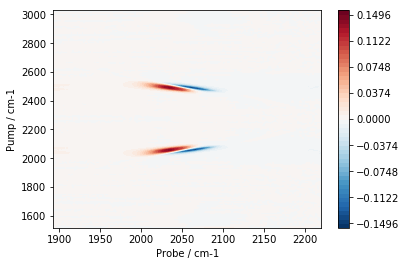

In [2]:
target = 'C:/pythonall/testset1'
polarisation = 'parallel'

display_dataset(target, polarisation, ranges=None)

Based on this output, specify the desired fitting area via the `ranges` dictionary. To enable fitting of crowded spectra and maximise the fitting speed, the fitting area should be as small as possible. 

By finding the coordinates of extrema in the dataset, the script suggests initial parameters for use as `p0` in `fit_dataset`. The `p0` array contains the following values: (`amplitude pos` ,  `amplitude neg` (absolute value),  `x-centre pos` ,  `x-centre neg` ,  `y-centre` ,  `x-sigma` ,  `y-sigma` ,  `theta` ,  `z-offset`).

Note that currently only the first 5 `p0` parameters are estimated in this method. 

Suggested p0:
(0.14077246, 0.155790281, 2034.101, 2062.472, 2057.7005872610002, '?', '?', '?', '?')


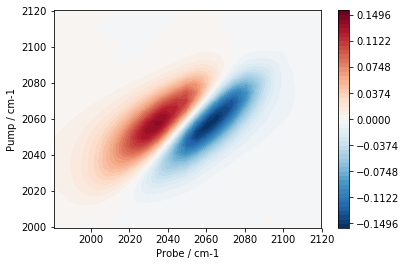

In [3]:
ranges = {'xlo': 1980, 'xhi': 2120, 'ylo': 2000, 'yhi': 2120}

display_dataset(target, polarisation, ranges)

## Peak selection

Depending on the value of the `peakselect` constant, the program performs a fit of either a linear combination of convolved two 2D Gaussians to the peak pair (`peakselect = 0`), or of a single 2D Gaussian to the positive (`peakselect = 1`) or negative (`peakselect = -1`) peak.

The `oneframe` boolean specifies whether to display just the first frame in the dataset (`oneframe = True`) for parameter optimisation, or run through the entire dataset (`oneframe = False`).

To save the figures and results table in the directory of raw spectra, select `savedata = True`.

-----------------------------


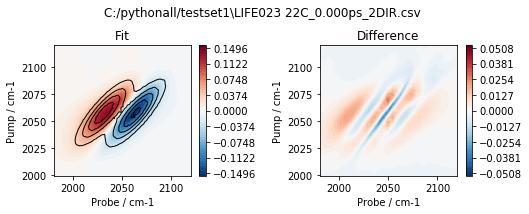

dir: C:/pythonall/testset1
pol: parallel
ranges: {'xlo': 1980, 'xhi': 2120, 'ylo': 2000, 'yhi': 2120}
p0: (0.14, 0.156, 2034, 2062, 2058, 25, 10, 0, 0)
peak: 0


,qfit,Ampl_1,Ampl_2,x0_1,x0_2,y_0,sigma_x,sigma_x_err,sigma_y,sigma_y_err,elipt,elipt_err,theta,theta_err,igrad,igrad_err
time,,,,,,,,,,,,,,,,
0.0,49.20572,0.141191,0.156227,2031.751322,2064.038773,2057.54882,22.377101,0.161495,6.550947,0.042569,0.842123,0.04054,0.806347,0.003267,0.958957,0.002718


In [4]:
peakselect = 0
p0 = (0.14, 0.156, 2034, 2062, 2058, 25, 10, 0, 0)

fit_dataset(target, peakselect, p0, ranges, polarisation, savedata=False, oneframe=True, showfig=True)

-----------------------------


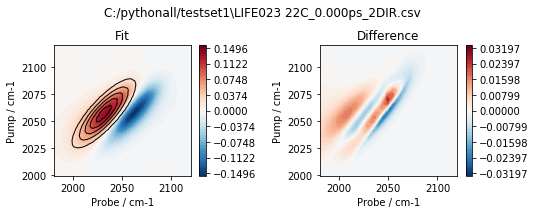

dir: C:/pythonall/testset1
pol: parallel
ranges: {'xlo': 1980, 'xhi': 2120, 'ylo': 2000, 'yhi': 2120}
p0: (0.14, 0.156, 2034, 2062, 2058, 25, 10, 0, 0)
peak: 1


,qfit,Ampl_1,Ampl_2,x0_1,x0_2,y_0,sigma_x,sigma_x_err,sigma_y,sigma_y_err,elipt,elipt_err,theta,theta_err,igrad,igrad_err
time,,,,,,,,,,,,,,,,
0.0,32.166111,0.138589,0.138589,2031.557666,2031.557666,2057.1438,23.268758,0.172251,7.24706,0.053708,0.823152,0.051959,0.793064,0.003479,0.984784,0.002914


In [5]:
peakselect = 1

fit_dataset(target, peakselect, p0, ranges, polarisation, savedata=False, oneframe=True, showfig=True)

-----------------------------


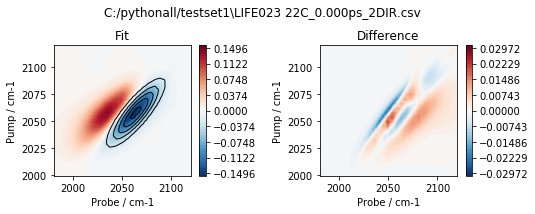

dir: C:/pythonall/testset1
pol: parallel
ranges: {'xlo': 1980, 'xhi': 2120, 'ylo': 2000, 'yhi': 2120}
p0: (0.14, 0.156, 2034, 2062, 2058, 25, 10, 0, 0)
peak: -1


,qfit,Ampl_1,Ampl_2,x0_1,x0_2,y_0,sigma_x,sigma_x_err,sigma_y,sigma_y_err,elipt,elipt_err,theta,theta_err,igrad,igrad_err
time,,,,,,,,,,,,,,,,
0.0,22.210874,0.161472,0.161472,2064.035538,2064.035538,2057.849008,22.720731,0.126808,6.522416,0.036426,0.847731,0.034881,0.823046,0.002395,0.927402,0.001975


In [6]:
peakselect = -1

fit_dataset(target, peakselect, p0, ranges, polarisation, savedata=False, oneframe=True, showfig=True)

## Run through entire dataset

The `fit_dataset` function has the results table as its output. To pass it to a further function it is named as `resulttable` here.

-----------------------------


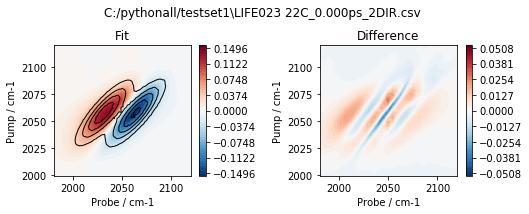

-----------------------------


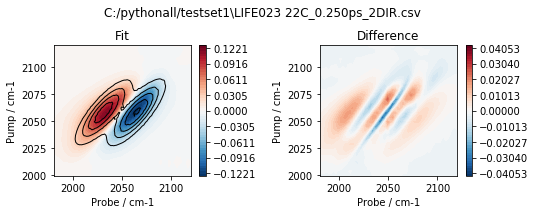

-----------------------------


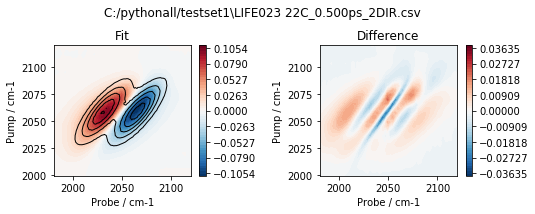

-----------------------------


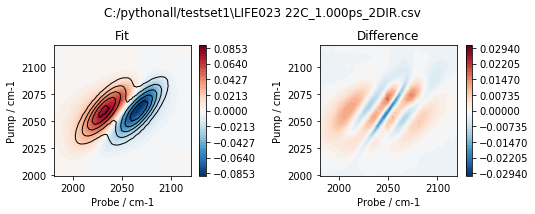

-----------------------------


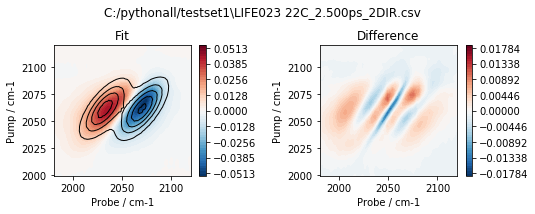

-----------------------------


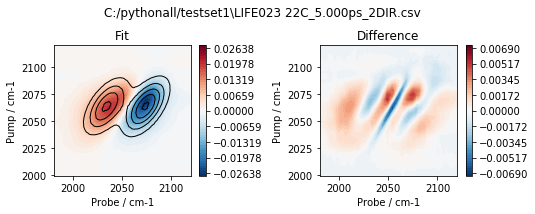

-----------------------------


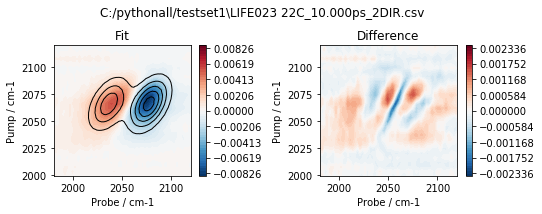

-----------------------------


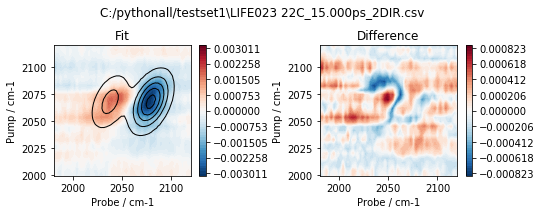

dir: C:/pythonall/testset1
pol: parallel
ranges: {'xlo': 1980, 'xhi': 2120, 'ylo': 2000, 'yhi': 2120}
p0: (0.14, 0.156, 2034, 2062, 2058, 25, 10, 0, 0)
peak: 0
             qfit    Ampl_1    Ampl_2         x0_1         x0_2          y_0  \
time                                                                           
0.00    49.205720  0.141191  0.156227  2031.751322  2064.038773  2057.548820   
0.25    52.135470  0.116821  0.127953  2031.156205  2064.671980  2058.119003   
0.50    54.734454  0.099943  0.110966  2031.213305  2065.647243  2058.676969   
1.00    57.384364  0.078646  0.088081  2031.443883  2067.062609  2059.502388   
2.50    60.388636  0.044838  0.051353  2032.512390  2070.356347  2061.470054   
5.00    61.931099  0.020677  0.025438  2034.183141  2073.857673  2063.721675   
10.00   75.459954  0.005470  0.008118  2036.678901  2077.308663  2066.017669   
15.00  213.344176  0.001256  0.003026  2037.817404  2079.180051  2067.979562   

         sigma_x  sigma_x_err   sigma_y

In [7]:
peakselect = 0
oneframe = False
savedata = True 

resulttable = fit_dataset(target, peakselect, p0, ranges, polarisation, savedata, oneframe, showfig=True)

print(resulttable)

## Graphing the results

Call `graph_ffcf` to visualise the results from above. This function requires `results` (the output of `fit_dataset`), `param` (the name of the column to be plotted) and `p0exp` (initial parameters for the monoexponential fitting).

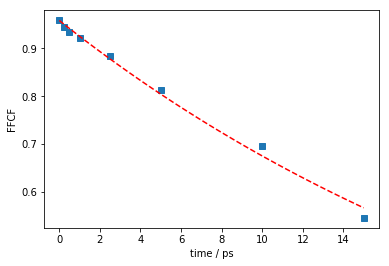

y = 0.95841 * exp(- t / 28.554)


In [8]:
results = resulttable
param = 'igrad'
p0exp = (0.1, 0.1)

graph_ffcf(results, param, p0exp)

## Crowded spectra

If the region you're attempting to fit has overlapping peaks, the fitting is unlikely to work when the selected region is too large. 

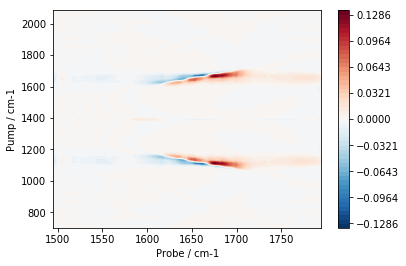

In [9]:
target = 'C:/pythonall/testset2'
polarisation = 'parallel'

display_dataset(target, polarisation, ranges=None)

Suggested p0:
(0.133933934, 0.127116358, 1676.252, 1661.301, 1665.61436425, '?', '?', '?', '?')
-----------------------------


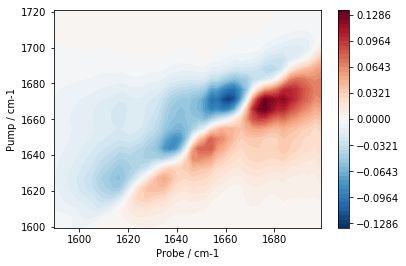

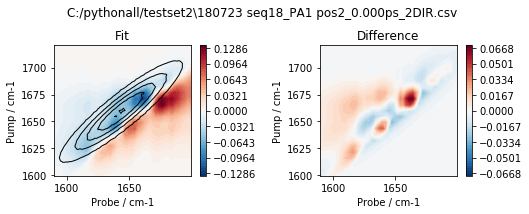

-----------------------------


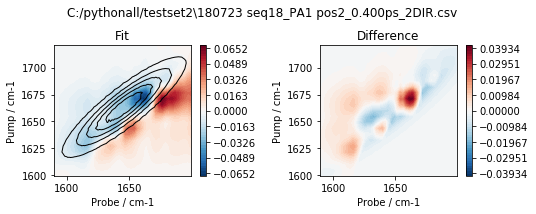

-----------------------------


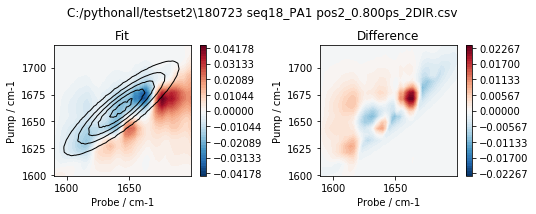

-----------------------------


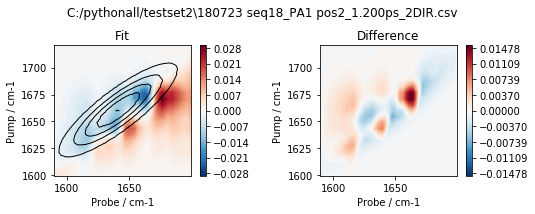

-----------------------------


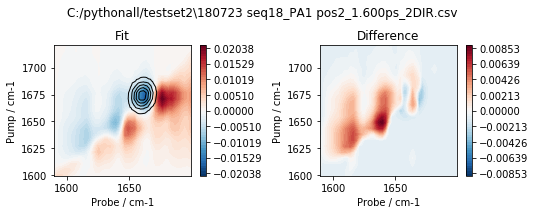

-----------------------------


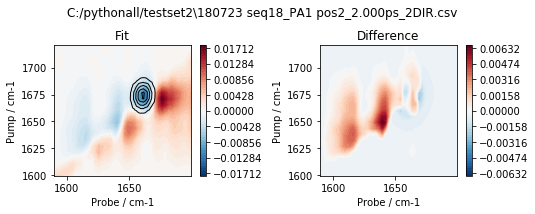

-----------------------------


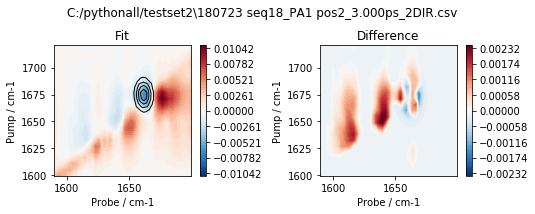

-----------------------------


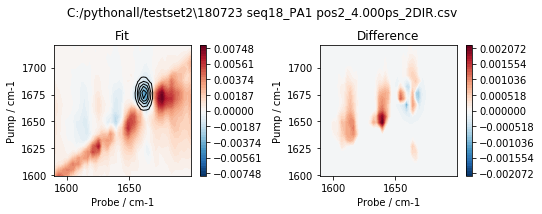

-----------------------------


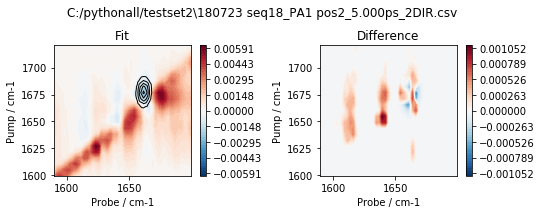

dir: C:/pythonall/testset2
pol: parallel
ranges: {'xlo': 1590, 'xhi': 1700, 'ylo': 1600, 'yhi': 1720}
p0: (0.14, 0.13, 1676, 1661, 1666, 5, 10, 0, 0)
peak: -1
            qfit    Ampl_1    Ampl_2         x0_1         x0_2          y_0  \
time                                                                          
0.0    87.519566  0.074999  0.074999  1643.329155  1643.329155  1659.189587   
0.4   102.291168  0.034643  0.034643  1645.755265  1645.755265  1663.248236   
0.8    94.645373  0.021065  0.021065  1643.603978  1643.603978  1662.205369   
1.2   106.113276  0.012318  0.012318  1641.000767  1641.000767  1660.590983   
1.6    70.937991  0.017173  0.017173  1660.365386  1660.365386  1674.151700   
2.0    61.685777  0.013124  0.013124  1660.665932  1660.665932  1674.130300   
3.0    42.664784  0.007277  0.007277  1661.482256  1661.482256  1674.728708   
4.0    32.106133  0.004633  0.004633  1661.754636  1661.754636  1675.544535   
5.0    25.484800  0.002640  0.002640  1661.531795  

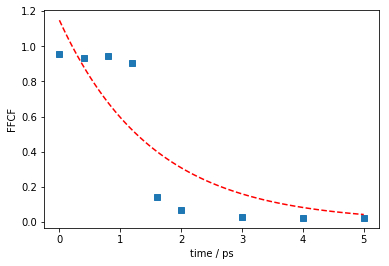

y = 1.1475 * exp(- t / 1.5235)


In [10]:
ranges = {'xlo': 1590, 'xhi': 1700, 'ylo': 1600, 'yhi': 1720}
display_dataset(target, polarisation, ranges)

peakselect = -1
p0 = (0.14, 0.13, 1676, 1661, 1666, 5, 10, 0, 0)

results2 = fit_dataset(target, peakselect, p0, ranges, polarisation, savedata=False, oneframe=False, showfig=True)
print(results2)

graph_ffcf(results2, 'igrad', (0.1, 0.1))

As can be seen, this yields unsatisfactory results. 

However with the same parameters, great results are obtained provided that the fitted area is selected more precisely via `ranges`.

Suggested p0:
(0.133933934, 0.127116358, 1676.252, 1661.301, 1665.61436425, '?', '?', '?', '?')
-----------------------------


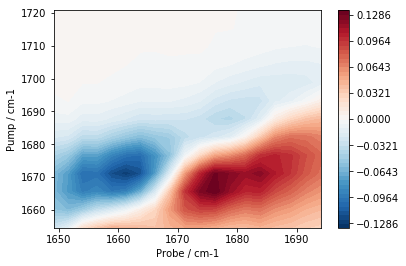

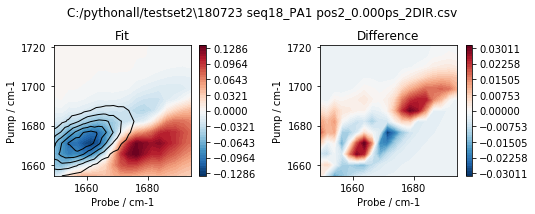

-----------------------------


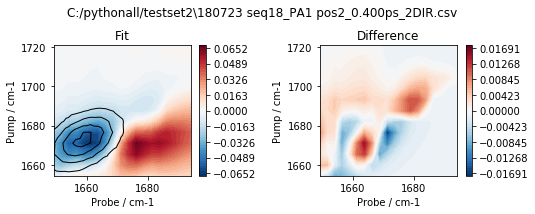

-----------------------------


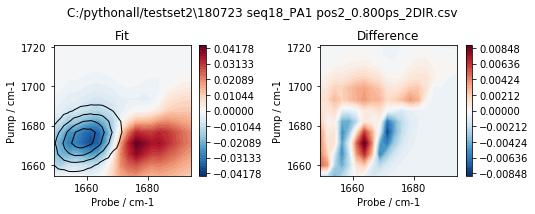

-----------------------------


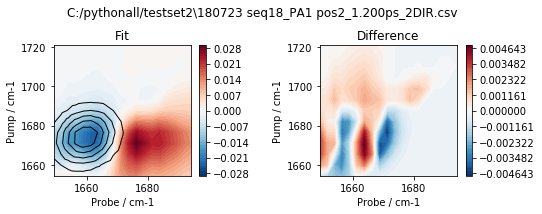

-----------------------------


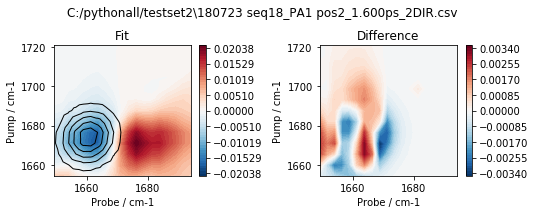

-----------------------------


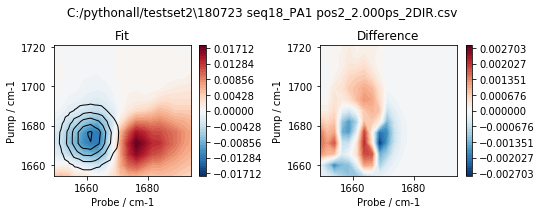

-----------------------------


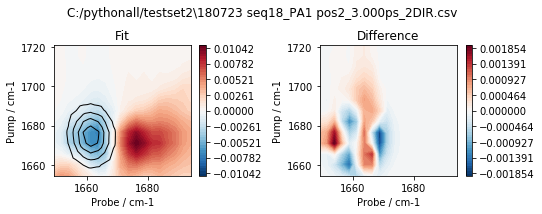

-----------------------------


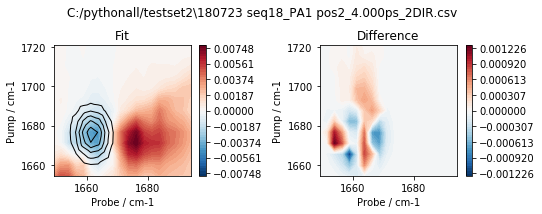

-----------------------------


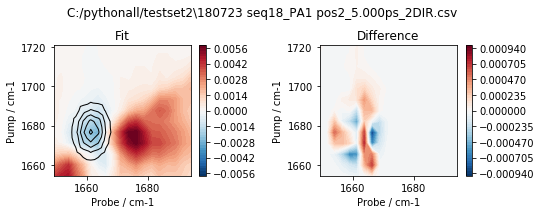

dir: C:/pythonall/testset2
pol: parallel
ranges: {'xlo': 1650, 'xhi': 1695, 'ylo': 1652, 'yhi': 1720}
p0: (0.14, 0.13, 1676, 1661, 1666, 5, 10, 0, 0)
peak: -1
           qfit    Ampl_1    Ampl_2         x0_1         x0_2          y_0  \
time                                                                         
0.0   11.646088  0.117713  0.117713  1658.490794  1658.490794  1671.899807   
0.4    9.960909  0.065730  0.065730  1658.791818  1658.791818  1672.778711   
0.8    9.253874  0.037617  0.037617  1658.961034  1658.961034  1673.674752   
1.2    8.487377  0.024359  0.024359  1659.621531  1659.621531  1674.402019   
1.6    7.803993  0.017758  0.017758  1660.518186  1660.518186  1674.279078   
2.0    6.777035  0.013325  0.013325  1660.683658  1660.683658  1674.232433   
3.0    6.775851  0.007277  0.007277  1661.447992  1661.447992  1674.791730   
4.0    5.942597  0.004625  0.004625  1661.737726  1661.737726  1675.582782   
5.0    5.992469  0.002634  0.002634  1661.523870  1661.523870

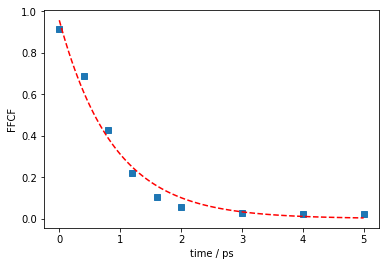

y = 0.9577 * exp(- t / 0.88986)


In [11]:
ranges = {'xlo': 1650, 'xhi': 1695, 'ylo': 1652, 'yhi': 1720}
display_dataset(target, polarisation, ranges)

peakselect = -1
p0 = (0.14, 0.13, 1676, 1661, 1666, 5, 10, 0, 0)

results2 = fit_dataset(target, peakselect, p0, ranges, polarisation, savedata=False, oneframe=False, showfig=True)
print(results2)

graph_ffcf(results2, 'igrad', (0.1, 0.1))

To demonstrate the power of the fitting method, the low (1645 cm-1) intensity peaks are fitted below.

Suggested p0:
(0.08044680400000001, 0.084243723, 1653.958, 1639.53, 1643.553246843, '?', '?', '?', '?')
-----------------------------


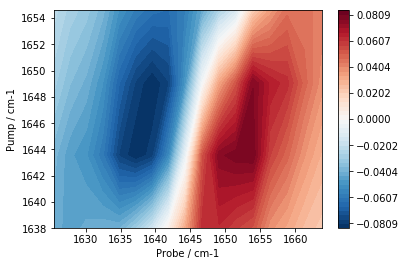

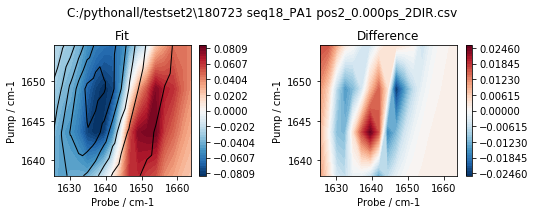

-----------------------------


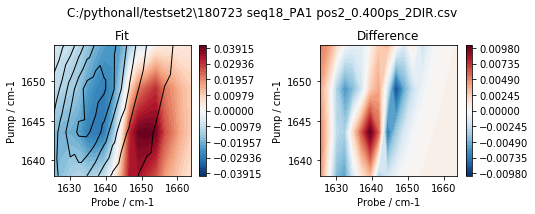

-----------------------------


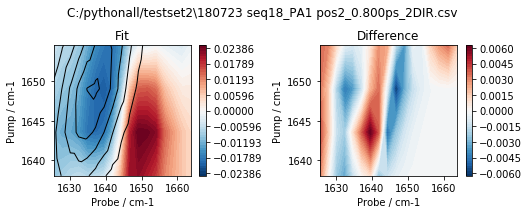

-----------------------------


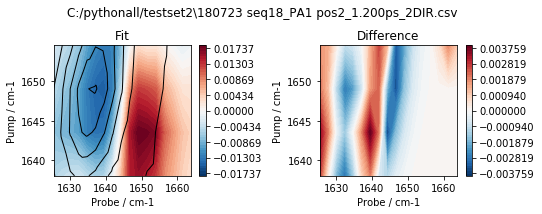

-----------------------------


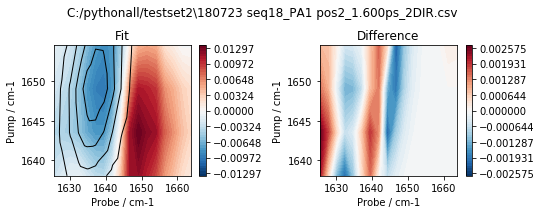

-----------------------------


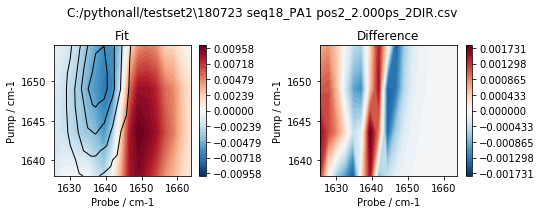

-----------------------------


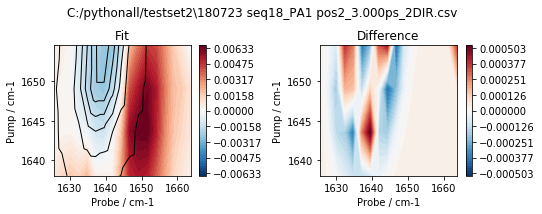

-----------------------------


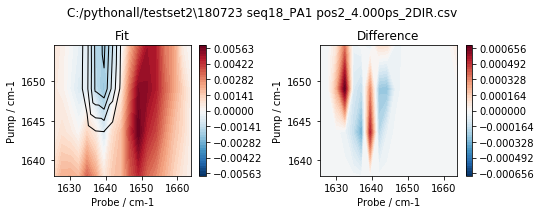

Error - curve_fit failed at t = 5.0
dir: C:/pythonall/testset2
pol: parallel
ranges: {'xlo': 1625, 'xhi': 1665, 'ylo': 1640, 'yhi': 1657}
p0: (0.1, 0.05, 1654, 1640, 1644, 10, 5, 0, 0)
peak: -1
          qfit    Ampl_1    Ampl_2         x0_1         x0_2          y_0  \
time                                                                        
0.0   4.822566  0.084530  0.084530  1636.587476  1636.587476  1648.228439   
0.4   5.449672  0.028924  0.028924  1635.993370  1635.993370  1647.610886   
0.8   5.609246  0.020870  0.020870  1636.607532  1636.607532  1649.011757   
1.2   5.055951  0.015528  0.015528  1636.252394  1636.252394  1648.780098   
1.6   4.636774  0.009929  0.009929  1637.125626  1637.125626  1649.435744   
2.0   5.186742  0.007129  0.007129  1638.002228  1638.002228  1650.363907   
3.0   2.512657  0.003047  0.003047  1638.885908  1638.885908  1652.472379   
4.0   1.974258  0.002495  0.002495  1638.870941  1638.870941  1652.046335   

        sigma_x  sigma_x_err   sigm

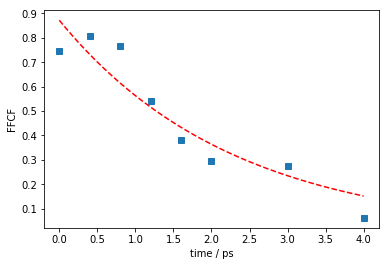

y = 0.87205 * exp(- t / 2.2871)


In [12]:
ranges = {'xlo': 1625, 'xhi': 1665, 'ylo': 1640, 'yhi': 1657}
display_dataset(target, polarisation, ranges)

peakselect = -1
p0 = (0.1, 0.05, 1654, 1640, 1644, 10, 5, 0, 0)

results = fit_dataset(target, peakselect, p0, ranges, polarisation, savedata=False, oneframe=False, showfig=True)
print(results)

graph_ffcf(results, 'igrad', (0.1, 0.1))